In [36]:
import torch
import gc
import torchvision.models as models
import torch.nn as nn

import dataloader
import trainer
import visualizer

## Main Functions

Auto-reload files imported to the notebook

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


For torch dataloader to use num_workers > 0, it relies on python multiprocessing, which in windows have deadlock issues, unless the instantiation is in a .py module and the code that invokes it is wrapped inside a \__main__ section.
https://github.com/pytorch/pytorch/issues/51344

torch.Size([3, 480, 640]) torch.Size([1, 480, 640])


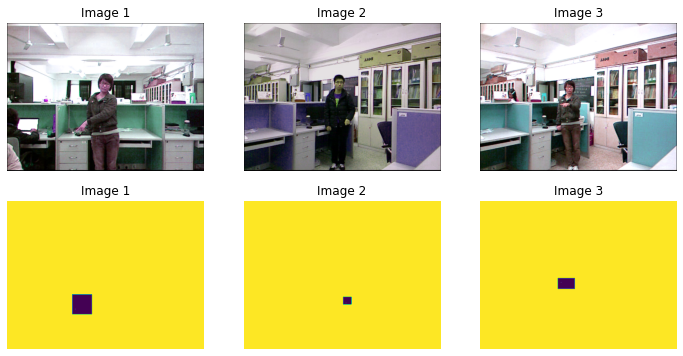

In [4]:
if __name__ == '__main__':
    loader_train, loader_val, loader_test = dataloader.main(batch_size=10, num_workers=3)

In [5]:
x, y = next(iter(loader_val))
print(x.shape, y.shape)

torch.Size([10, 3, 480, 640]) torch.Size([10, 1, 480, 640])


In [6]:
# Free cuda memory
# Reference: https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/13
def freemem():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and torch.is_tensor(obj.data):
            del obj
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

## Resnet18 Without tiles and utilizing the full dataset

Here we import the resnet18 model with pretrained weights. This gives us some good starting weights so that we don't have to train the model from scratch.

In [7]:
resnet18_notile_full = models.resnet18(pretrained=True)

From there, we replace the last layer to work with the tiles format rather than Resnet's standard classification. Lastly, we freeze all of the layers except for the newly added layer so that it can be trained individually

In [8]:
resnet18_notile_full.fc = nn.Linear(512, 480*640)
print(resnet18_notile_full.fc)

Linear(in_features=512, out_features=307200, bias=True)


##### NOTE: If you want to load the saved model then skip then section and run from the Visualize Model section

In [9]:
for param in resnet18_notile_full.parameters():
    param.require_grad = False
resnet18_notile_full.fc.requires_grad_(True)

Linear(in_features=512, out_features=307200, bias=True)

Now let's train the model!

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
resnet18_notile_full = resnet18_notile_full.to(device)
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=1, patience=10)

Device: cuda
Training epoch 1 batch 1250/2500, train loss = 0.049626, train acc = 0.987078, recall = 0.996060, precision = 0.990950
validation metrics at epoch 1 batch 1250: val loss = 0.025874, val acc = 0.992196, val recall = 0.999332, val precision = 0.992841
Training epoch 1 batch 2500/2500, train loss = 0.035101, train acc = 0.990042, recall = 0.997689, precision = 0.992305
validation metrics at epoch 1 batch 2500: val loss = 0.014872, val acc = 0.994686, val recall = 0.998566, val precision = 0.996082
Epoch 1/1 train loss = 0.035101, train acc = 0.990042, val loss = 0.014872, val acc = 0.994686


([0.025874350952605405, 0.014871575062473615],
 [0.9921959137916565, 0.9946855831146241])

Unfreeze the layers and train with the fully unfrozen model

In [11]:
for param in resnet18_notile_full.parameters():
    param.require_grad = True
trainer.train(resnet18_notile_full, loader_train, loader_val, lr=1e-4, device=device, num_epochs=1, patience=10)

torch.save(resnet18_notile_full.state_dict(), 'saved_models/resnet18_notile_full.model')

Training epoch 1 batch 1250/2500, train loss = 0.014335, train acc = 0.994571, recall = 0.998969, precision = 0.995568
validation metrics at epoch 1 batch 1250: val loss = 0.010687, val acc = 0.995988, val recall = 0.998554, val precision = 0.997400
Training epoch 1 batch 2500/2500, train loss = 0.012832, train acc = 0.995025, recall = 0.998924, precision = 0.996067
validation metrics at epoch 1 batch 2500: val loss = 0.009463, val acc = 0.996447, val recall = 0.998381, val precision = 0.998035
Epoch 1/1 train loss = 0.012832, train acc = 0.995025, val loss = 0.009463, val acc = 0.996447


## Model Visualizations

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


Load the model if you dont want to train it

In [13]:
resnet18_notile_full.load_state_dict(torch.load('saved_models/resnet18_notile_full.model', map_location=torch.device(device)))
resnet18_notile_full = resnet18_notile_full.to(device)

Accuracy = 99.65556859970093%
Precision = 69.64490413665771%
Recall = 87.29915022850037%


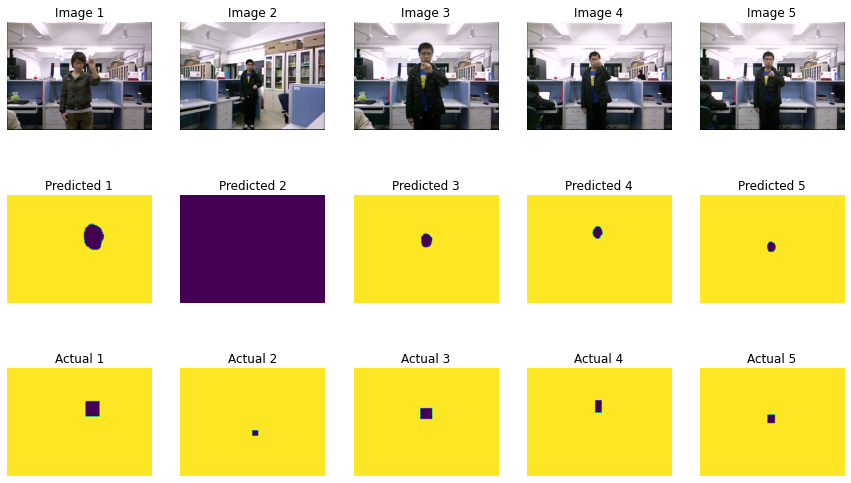

In [47]:
visualizer.visualize_model_output(loader_test, resnet18_notile_full, device=device)